# Partie 3 : Modélisation

# A. Etude des causalités entre paramètres

Premièrement, nous allons étudier la significativité et l'importance des causalités que nous avons commencé à étudier avec les matrices de corrélation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df[['Année']] = df[['Année']].astype(object)

df_correl = df.iloc[:, [0,21,22,23,24]]

df_feu = df[df['Départ de feu'] == 1]
df_feu = df_feu.drop(columns = ['Départ de feu'])
df_feu = df_feu.sort_values(['Date de première alerte'])
df_feu = df_feu.reset_index(drop = True)

df_feu_correl = df_feu.iloc[:,[8,20,21,22,23]]

C:\Users\theoc\anaconda3\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,3,4,5,6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:>

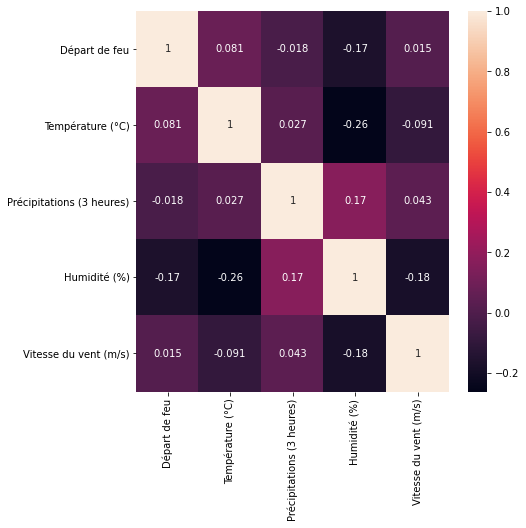

In [3]:
val = df_correl.corr()
plt.figure(figsize = (7,7))
sns.heatmap(val, annot = True)

<AxesSubplot:>

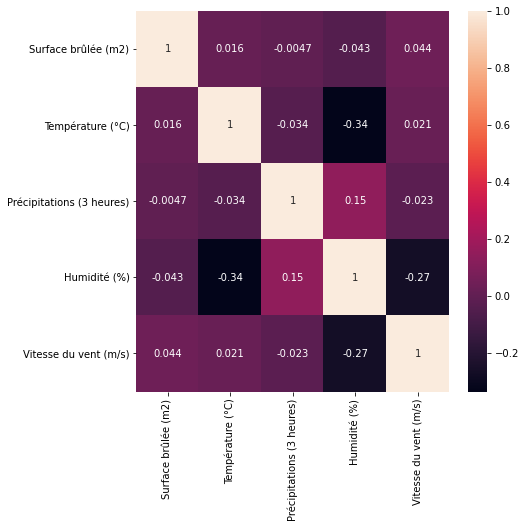

In [4]:
val2 = df_feu_correl.corr()
plt.figure(figsize = (7,7))
sns.heatmap(val2, annot = True)

Ces deux matrices nous donnent des corrélations plutôt faibles, surtout pour ce qui nous intéresse (corrélations avec "Départ de feu" et "Surface brûlée").

Il faut donc étudier plus en détail pour savoir si l'on peut vraiment tirer des conclusions.

**Utilisation de statsmodels.api pour obtenir les coeff, la p-value et l'intervalle de confiance à 95% comme avec Stata lors des régressions linéaires**

https://www.statsmodels.org/devel/install.html

Nous allons évaluer la significativité de nos coefficients de corrélation précédents grâce à cet API.

In [5]:
import statsmodels.api as sm
#pour l'installer : conda install -c conda-forge statsmodels

Voici un exemple avec cet API : 

In [6]:
x = df_correl['Température (°C)']
x = sm.add_constant(x)
y = df_correl['Humidité (%)']

modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                            OLS Regression Results                            
Dep. Variable:           Humidité (%)   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.722e+05
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:40:05   Log-Likelihood:            -9.8593e+06
No. Observations:             2346154   AIC:                         1.972e+07
Df Residuals:                 2346152   BIC:                         1.972e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               82.7656      0.020  

On peut représenter les données ainsi que la droite obtenue avec la régression OLS :

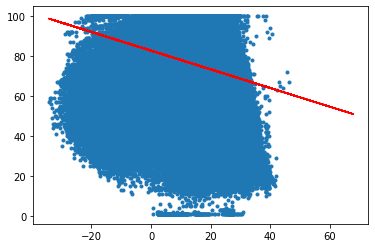

In [7]:
x = df_correl['Température (°C)']
y = df_correl['Humidité (%)']
plt.plot(x, y,'.')
plt.plot(x, resultats.params[1]*x + resultats.params[0], 'red')

Ce qui nous intéresse pour évaluer la significativité des causalités est le "coefficient de la pente", la p-value et l'intervalle de confiance à 95% :

Exemple détaillé pour mieux comprendre la suite :

Dans la matrice de corrélation, nous avons obtenu une corrélation de -0.26.

Ici, la causalité entre la température et l'humidité est significative statistiquement car la p-value du coefficient de la pente est nulle.  

Le coefficient de la pente (-0.47) signifie que pour 1°C en plus, l'humidité descend de 0.47%, ce qui est non-négligeable. De plus, l'intervalle de confiance à 95% est [ -0.47 ; -0.466 ], ce qui est très précis.
On peut alors dire que la causalité est significative en pratique.

Donc la causalité entre température et humidité est significative.

Par la suite, nous allons faire des régressions sur plusieurs variables de contrôle pour **limiter les biais de variables omises.**

**1) Causalité entre "Départ de feu" et les variables météo**

**a) Température (°C)**

In [9]:
x = df_correl.iloc[:, [0,2,3,4]]
x = sm.add_constant(x)
y = df_correl.iloc[:, 1]
        
modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                            OLS Regression Results                            
Dep. Variable:       Température (°C)   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                 9.867e+04
Date:                Thu, 10 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:44:20   Log-Likelihood:            -7.0155e+06
No. Observations:             2031491   AIC:                         1.403e+07
Df Residuals:                 2031486   BIC:                         1.403e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

p-value = 0 donc la causalité est significative statistiquement.

Si il y a un **départ de feu**, alors la **température augmente de 2.7°C,** ce qui est non-négligeable. Intervalle de confiance précis.
La causalité est donc également significative en pratique.

**Donc la causalité entre départ de feu et température est significative.** Pourtant on avait une corrélation faible (0.081) donc on a bien fait de faire cette étude.

**b) Précipitations des 3 dernières heures (mm)**

In [45]:
x = df_correl.iloc[:, [0,1,3,4]]
x = sm.add_constant(x)
y = df_correl.iloc[:, 2]
        
modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                                OLS Regression Results                               
Dep. Variable:     Précipitations (3 heures)   R-squared:                       0.044
Model:                                   OLS   Adj. R-squared:                  0.044
Method:                        Least Squares   F-statistic:                 2.348e+04
Date:                       Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                               23:54:05   Log-Likelihood:            -3.9005e+06
No. Observations:                    2031491   AIC:                         7.801e+06
Df Residuals:                        2031486   BIC:                         7.801e+06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

p-value = 0 donc la causalité est significative statistiquement.

Si il y a un départ de feu, alors les précipitations des 3 dernières heures augmentent de 0.1mm.
La causalité n'est pas significative en pratique car 0.1mm de pluie de différence est négligeable. En plus, ce n'est pas logique que le départ de feu augmente les précipitations. Cela montre bien qu'il n'y a pas de causalité.

**Donc on ne peut pas établir de lien entre départ de feu et précipitations dans les 3 dernières heures.** On avait également une corrélation très faible (-0.018). Comme dit dans la Partie2, il faudrait les données des précipitations dans les 24 dernières heures pour avoir plus de chances d'obtenir un résultat convaincant. On se doute que la pluie devrait impacter négativement sur les départs de feux.

**c) Humidité (%)**

In [46]:
x = df_correl.iloc[:, [0,1,2,4]]
x = sm.add_constant(x)
y = df_correl.iloc[:, 3]
        
modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                            OLS Regression Results                            
Dep. Variable:           Humidité (%)   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                 1.509e+05
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:54:55   Log-Likelihood:            -8.3854e+06
No. Observations:             2031491   AIC:                         1.677e+07
Df Residuals:                 2031486   BIC:                         1.677e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

p-value = 0 donc la causalité est significative statistiquement.

Si il y a un **départ de feu**, alors **l'humidité diminue de 17.3%,** ce qui est non-négligeable. Intervalle de confiance précis.
La causalité est également significative en pratique.

**Donc la causalité entre départ de feu et humidité est significative.** Pourtant on avait une corrélation faible (-0.17) donc on a bien fait de faire cette étude.

**d) Vitesse du vent (m/s)**

In [47]:
x = df_correl.iloc[:, [0,1,2,3]]
x = sm.add_constant(x)
y = df_correl.iloc[:, 4]
        
modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                              OLS Regression Results                             
Dep. Variable:     Vitesse du vent (m/s)   R-squared:                       0.051
Model:                               OLS   Adj. R-squared:                  0.051
Method:                    Least Squares   F-statistic:                 2.751e+04
Date:                   Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                           23:59:03   Log-Likelihood:            -5.0267e+06
No. Observations:                2031491   AIC:                         1.005e+07
Df Residuals:                    2031486   BIC:                         1.005e+07
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

p-value = 0.405 donc la causalité n'est pas significative statistiquement.

Si il y a un départ de feu, alors la vitesse du vent augmente de 0.013m/s. Intervalle de confiance pas précis.
La causalité n'est pas significative en pratique car 0.013m/s de différence est négligeable.

**Donc on ne peut pas établir de lien entre départ de feu et vitesse du vent.** On avait également une corrélation très faible (0.015).

**2) Causalité entre surface brûlée et les variables météo**

On effectue une régression linéaire de la surface brûlée sur la température, les précipitations des 3 dernières heures, l'humidité et la vitesse du vent :

In [32]:
x = df_feu_correl.iloc[:, 1:5]
x = sm.add_constant(x)
y = df_feu_correl.iloc[:, 0]
        
modele = sm.OLS(y, x, missing = 'drop')
resultats = modele.fit()
print(resultats.summary())

                             OLS Regression Results                            
Dep. Variable:     Surface brûlée (m2)   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     24.77
Date:                 Wed, 09 Dec 2020   Prob (F-statistic):           1.65e-20
Time:                         23:03:05   Log-Likelihood:            -4.7295e+05
No. Observations:                32807   AIC:                         9.459e+05
Df Residuals:                    32802   BIC:                         9.459e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const       

On voit que la p-value et l'intervalle de confiance pour la température et les précipitations sont énormes, donc **on ne peut pas admettre de causalité entre la surface brûlée et la température/précipitations.**

Par contre, pour l'humidité et la vitesse du vent, les p-value sont nulles et les intervalles de confiance dont les valeurs extrêmes restent du même signe. **On peut donc admettre une causalité entre la surface brûlée et l'humidité/vitesse du vent.**

1% d'humidité en plus diminue la surface brûlée de 766 m2.
1m/s en plus de vitesse pour le vent augmente la surface brûlée de 5239 m2 soit près d'un demi hectare ! C'est énorme.

**Pour conclure,** les variables météo qui impactent significativement le **départ d'un feu** sont la **température et l'humidité**.
Tandis que les variables météo qui impactent significativement la **propagation d'un feu** sont **l'humidité et la vitesse du vent.**

Comme dit précédemment, les précipitations doivent sûrement être corrélées négativement sur les départs et propagations de feux, mais il faudrait les données sur les 24 dernières heures au moins. Nous avons seulement les données sur les 3 dernières heures ce qui n'est pas suffisant. En effet, s'il pleut depuis 20h mais que sur les 3h avant le départ du feu il ne pleut plus, la forêt et le sol sont toujours trempés mais on ne le comptabilise pas dans les précipitations.

**On retrouve les mêmes résultats que l'on avait pressenti dans la Partie2.**